# Agentic_rag_simplified assignment 4

In [ ]:
# !pip install langgraph

In [84]:
import pandas as pd
import time
import json, os, re
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from azure.keyvault.secrets import SecretClient
from azure.identity import DefaultAzureCredential
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field
from langfuse.callback import CallbackHandler
from langchain_chroma import Chroma
from typing import TypedDict, List, Dict
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.schema.runnable import RunnableMap, RunnableLambda
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display

In [35]:
KVUri = "https://dipanjans-kv.vault.azure.net"
credential = DefaultAzureCredential()
client = SecretClient(vault_url=KVUri, credential=credential)

oai_endpoint= client.get_secret("azure-openai-endpoint")
oai_key=      client.get_secret("azure-openai-key")
oai_endpoint_embed= client.get_secret("azure-openai-endpoint-embed")
oai_key_embed=      client.get_secret("azure-openai-key-embed")


langfuse_sk= client.get_secret("langfuse-secret-key-2")
langfuse_pk= client.get_secret("langfuse-public-key-2")
langfuse_host= client.get_secret("langfuse-host-1")

llm = AzureChatOpenAI(api_version="2024-12-01-preview",
                        model='gpt-40-mini' , 
                        azure_endpoint= oai_endpoint.value,
                        api_key = oai_key.value)

embeds = AzureOpenAIEmbeddings(azure_deployment="dipanjan_ada_embed_150k",
                        model = 'text-embedding-ada-002',
                        azure_endpoint= oai_endpoint_embed.value,
                        api_key = oai_key_embed.value)

###### Testing llm and embed model ######
out = (embeds.embed_query("who is this?"), llm.invoke("who is this?"))
print(out[0])
print("****")
print(out[1])

[-0.0036209106910973787, -0.0019214411731809378, -0.015662867575883865, -0.011667379178106785, -0.011625759303569794, 0.018201665952801704, -0.006277632433921099, 0.014761107042431831, -0.01422005146741867, -0.013519453816115856, 0.017549624666571617, -0.0026081656105816364, -0.008025658316910267, -0.020352015271782875, 0.012118258513510227, 0.003003552323207259, 0.0225994773209095, 0.004588568117469549, 0.004494923632591963, -0.014129876159131527, -0.028287498280405998, 0.009225692600011826, -0.01190322358161211, -0.0018607458332553506, 0.0032810168340802193, 0.0209346916526556, 0.014261671341955662, -0.019339270889759064, -0.0011072565102949739, -0.02963319979608059, 0.010439598932862282, -0.017757723107933998, 0.007470729760825634, -0.02930024266242981, -0.009135516360402107, -0.009933226741850376, 0.015302163548767567, -0.015510261058807373, 0.00044567722943611443, 0.01018988061696291, 0.016911456361413002, -0.0045226700603961945, 0.006392086856067181, 0.004498391877859831, -0.0146

In [71]:
class agentic_ragState_as_4(TypedDict):
    user_question: str
    kb_hits: List[Dict]
    initial_answer: str
    critique_result: str
    refined_answer: str

# Retriever_node

In [72]:
def retriever_node(state:agentic_ragState_as_4) -> List[Dict]: 
    out_dict, doc_ids = [],[]
    chroma_db = Chroma(collection_name= 'assignment_4_vec_index',
                embedding_function= embeds, persist_directory= 'assignment_4_vec_index')
    retriever = chroma_db.as_retriever(search_type="similarity", search_kwargs={"k": 5})
    ret_docs = retriever.invoke(state["user_question"])
    
    for i in ret_docs:
        doc_ids.append(i.id)
        out_dict.append({'doc_id': i.id,
        'source': i.metadata.get('source'),
        'question': i.metadata.get('question'),
        'answer_snippet': i.page_content})
    print("In retriever node, docs retrieved ", doc_ids)
    return {"kb_hits":out_dict}

###########  Testing sample retriever node output
sample_test_state = {"user_question": "What are best practices for caching?"} # Testing sample retriever node output
# retriever_node(sample_test_state) # Testing sample retriever node output
sample_test_state.update(retriever_node(sample_test_state))
print(sample_test_state)

In retriever node, docs retrieved  ['KB003', 'KB013', 'KB023', 'KB002', 'KB012']
{'user_question': 'What are best practices for caching?', 'kb_hits': [{'doc_id': 'KB003', 'source': 'caching_guide.md', 'question': 'What are best practices for caching?', 'answer_snippet': "When addressing caching, it's important to follow well-defined patterns..."}, {'doc_id': 'KB013', 'source': 'caching_guide.md', 'question': 'What are best practices for caching?', 'answer_snippet': "When addressing caching, it's important to follow well-defined patterns..."}, {'doc_id': 'KB023', 'source': 'caching_guide.md', 'question': 'What are best practices for caching?', 'answer_snippet': "When addressing caching, it's important to follow well-defined patterns..."}, {'doc_id': 'KB002', 'source': 'performance tuning_guide.md', 'question': 'What are best practices for performance tuning?', 'answer_snippet': "When addressing performance tuning, it's important to follow well-defined patterns..."}, {'doc_id': 'KB012', 

# Generate answer node

In [73]:
def generate_answer_node(state:agentic_ragState_as_4) -> str: 
    retrieved_snippets = ''
    doc_ids  = []
    for hit in state['kb_hits']:
        doc_ids.append(hit['doc_id'])
        retrieved_snippets += "doc_id: " + hit['doc_id'] + '\n' + 'snippet: ' + hit['answer_snippet'] + '\n******\n'
    
    print("Generating initial answer......")
    generate_prompt = """You are a software best-practices assistant.
                User Question:
                {user_question}
                
                Retrieved Snippets:
                {retrieved_snippets}

                Task:
                Based on these snippets, write a concise answer to the user’s question.
                Cite each snippet you use by its doc_id in square brackets (e.g., [KB004]).
                Return only the answer text. """
    generate_prompt = PromptTemplate.from_template(generate_prompt)
    messages = generate_prompt.invoke({"user_question":state["user_question"],"retrieved_snippets":retrieved_snippets})
    return {'initial_answer':llm.invoke(messages).content}
    
    # return {"initial_answer": initial_answer}


############## testing generation #####
sample_test_state.update(generate_answer_node(sample_test_state))
sample_test_state['initial_answer']


Generating initial answer......


"When addressing caching, it's important to follow well-defined patterns to ensure efficient storage and retrieval of data, maintainability, and scalability. Be mindful of cache expiration policies, consistency models, and appropriate cache invalidation strategies to prevent stale data from being served. Additionally, consider the trade-offs between memory usage and performance benefits, and monitor cache performance to adapt as needed [KB003][KB013][KB023]."

# Self critique node

In [74]:
def critique_answer_node(state:agentic_ragState_as_4) -> str: 
    retrieved_snippets = ''
    doc_ids  = []
    for hit in state['kb_hits']:
        doc_ids.append(hit['doc_id'])
        retrieved_snippets += "doc_id: " + hit['doc_id'] + '\n' + 'snippet: ' + hit['answer_snippet'] + '\n******\n'
    
    print("Critic analysis in progress......")
    generate_prompt = """You are a critical QA assistant. The user asked: {user_question}
                        Initial Answer:
                        {initial_answer}

                        Snippets:
                        {snippets}

                        Task:
                        Determine if the initial answer fully addresses the question using only these snippets.
                        - If it does, respond exactly: COMPLETE
                        - If it misses any point or cites missing info, respond: REFINE: <short list of missing topic keywords>

                        Return exactly one line."""
    generate_prompt = PromptTemplate.from_template(generate_prompt)
    messages = generate_prompt.invoke({"user_question":state["user_question"],
                                    "initial_answer": state["initial_answer"],
                                    "snippets":retrieved_snippets})
    return {'critique_result':llm.invoke(messages).content}


############## testing generation #####
sample_test_state.update(critique_answer_node(sample_test_state))
sample_test_state['critique_result']


Critic analysis in progress......


'REFINE: cache expiration policies, consistency models, cache invalidation strategies, memory usage, performance monitoring'

# Refinement node

In [75]:
def refine_answer_node(state:agentic_ragState_as_4) -> str: 
    critique_result= state['critique_result']
    critique_result = re.sub(r"^REFINE\W+", "", critique_result.strip(), flags=re.IGNORECASE)
    # user_qn = re.sub(r"[?.,!:;]+$", "", state['user_question'])
    new_query = f"{state['user_question']} Give me information on {critique_result}"
    
    out_dict, doc_ids = [],[]
    chroma_db = Chroma(collection_name= 'assignment_4_vec_index',
                embedding_function= embeds, persist_directory= 'assignment_4_vec_index')
    retriever = chroma_db.as_retriever(search_type="similarity", search_kwargs={"k": 1})
    ret_docs = retriever.invoke(new_query)
    additional_snippets = ''
    for i in ret_docs:
        doc_ids.append(str(i.id))
        additional_snippets = additional_snippets+ 'doc_id:' + str(i.id) + "/n" + i.page_content + '\n'
    
    print("Answer refinement in progress......")
    print("Query modified: ", new_query)
    print("Additional snippet picked: ", doc_ids)
    refine_prompt = """You are a software best-practices assistant refining your answer.
                        The user asked: {user_question}
                        
                        Initial Answer:
                        {initial_answer}
                        
                        Critique: {critique_result}

                        Additional Snippet:
                        {additional_snippets}

                        Task:
                        Incorporate this snippet into the answer, covering the missing points.
                        Cite any snippet you use by doc_id in square brackets.
                        Return only the final refined answer."""
    refine_prompt = PromptTemplate.from_template(refine_prompt)
    messages = refine_prompt.invoke({"user_question":state["user_question"],
                                    "initial_answer": state["initial_answer"],
                                    "critique_result": state["critique_result"],
                                    "additional_snippets":additional_snippets})
    return {'refined_answer':llm.invoke(messages).content}


############## testing generation #####

sample_test_state.update(refine_answer_node(sample_test_state))
sample_test_state['refined_answer']


Answer refinement in progress......
Query modified:  What are best practices for caching? Give me information on cache expiration policies, consistency models, cache invalidation strategies, memory usage, performance monitoring
Additional snippet picked:  ['KB013']


"When addressing caching, it's important to follow well-defined patterns to ensure efficient storage and retrieval of data, maintainability, and scalability. Key best practices include:\n\n1. **Cache Expiration Policies**: Define clear expiration times for cached data to balance freshness and performance. Consider settings like Time-to-Live (TTL) to automatically invalidate stale entries.\n\n2. **Consistency Models**: Choose an appropriate consistency model based on your application's needs. Options may include strong consistency, eventual consistency, or session consistency, depending on how critical it is for users to see the most up-to-date data.\n\n3. **Cache Invalidation Strategies**: Implement robust cache invalidation strategies to ensure data consistency. This can be achieved through techniques such as write-through, write-back, or lazy invalidation, depending on system requirements.\n\n4. **Memory Usage Management**: Be mindful of memory consumption by monitoring and optimizin

# Router node for deficient queries 

In [76]:
def decision_node(state:agentic_ragState_as_4) -> str: 
    if state['critique_result'].startswith("REFINE"):
        return "refine"
    elif state['critique_result'].startswith("COMPLETE"):
        return "complete"

############## testing generation #####
decision_node(sample_test_state)
# sample_test_state.update(critique_answer_node(sample_test_state))
# sample_test_state['critique_result']


'refine'

# Build graph

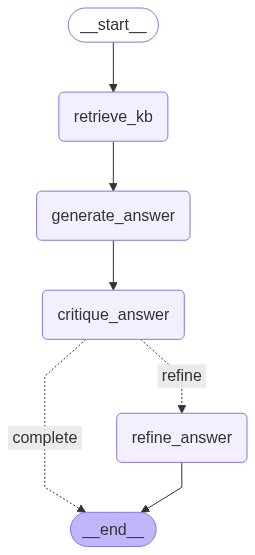

In [85]:
graph = StateGraph(agentic_ragState_as_4)

graph.add_node("retrieve_kb", retriever_node)
graph.add_node("generate_answer", generate_answer_node)
graph.add_node("critique_answer", critique_answer_node)
graph.add_node("refine_answer", refine_answer_node)

graph.add_edge(START, 'retrieve_kb')
graph.add_edge('retrieve_kb', 'generate_answer')
graph.add_edge('generate_answer', 'critique_answer')
graph.add_conditional_edges('critique_answer', decision_node, {'refine': 'refine_answer', 'complete': END})


compiled_graph= graph.compile()

display(Image(compiled_graph.get_graph().draw_mermaid_png()))


In [ ]:
langfuse_sk = 'sk-lf-f85dca93-2224-4be7-ac5c-4c762c15b704'
langfuse_pk = 'pk-lf-cdfe6fea-7611-4148-b563-b9613b942386'
langfuse_host= "http://localhost:3000"

import uuid

unique_id = str(uuid.uuid4())


langfuse_handler = CallbackHandler(
    secret_key= langfuse_sk,
    public_key=langfuse_pk,
    host=langfuse_host,
    session_id = f'agentic_rag_session_{unique_id}'
)

compiled_graph.invoke({'user_question':'What should I consider for error handling?'}, config= {"callbacks": [langfuse_handler]})

a732b992-1b19-464c-8634-816bd954b6dc
In retriever node, docs retrieved  ['KB009', 'KB019', 'KB029', 'KB001', 'KB021']
Generating initial answer......
Critic analysis in progress......
Answer refinement in progress......
Query modified:  What should I consider for error handling? Give me information on structured error handling, logging errors, meaningful messages, graceful recovery, sensitive information
Additional snippet picked:  ['KB029']


{'user_question': 'What should I consider for error handling?',
 'kb_hits': [{'doc_id': 'KB009',
   'source': 'error handling_guide.md',
   'question': 'What are best practices for error handling?',
   'answer_snippet': "When addressing error handling, it's important to follow well-defined patterns..."},
  {'doc_id': 'KB019',
   'source': 'error handling_guide.md',
   'question': 'What are best practices for error handling?',
   'answer_snippet': "When addressing error handling, it's important to follow well-defined patterns..."},
  {'doc_id': 'KB029',
   'source': 'error handling_guide.md',
   'question': 'What are best practices for error handling?',
   'answer_snippet': "When addressing error handling, it's important to follow well-defined patterns..."},
  {'doc_id': 'KB001',
   'source': 'debugging_guide.md',
   'question': 'What are best practices for debugging?',
   'answer_snippet': "When addressing debugging, it's important to follow well-defined patterns..."},
  {'doc_id': 'KB